In [55]:
from google.colab import files
uploaded = files.upload()


Saving a3_run_afd99f86fe.jsonl to a3_run_afd99f86fe.jsonl


In [56]:
%matplotlib inline
plt.rcParams["figure.dpi"] = 140


In [68]:
import json
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd

def read_jsonl(
    path: str,
    *,
    keep_bad_lines: bool = False,
    max_bad_preview: int = 5,
) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    bad = 0
    previews: List[Tuple[int, str, str]] = []

    with open(path, "r", encoding="utf-8") as f:
        for line_no, line in enumerate(f, 1):
            s = line.strip()
            if not s:
                continue
            try:
                rows.append(json.loads(s))
            except json.JSONDecodeError as e:
                bad += 1
                if keep_bad_lines:
                    rows.append({"_bad_json": True, "_line_no": line_no, "_raw": s})
                if len(previews) < max_bad_preview:
                    previews.append((line_no, str(e), s[:250]))

    if bad:
        print(f"[read_jsonl] {Path(path).name}: ok={len(rows)-bad} bad={bad}")
        for line_no, err, snippet in previews:
            print(f"  bad line {line_no}: {err}\n    {snippet}")
    return rows


#Helpers for safe metric/key extraction
def _is_finite_number(x: Any) -> bool:
    return isinstance(x, (int, float)) and np.isfinite(x)

def _emit_long(
    out: List[Dict[str, Any]],
    *,
    label: str,
    t_global: Any,
    k_used_total: Any,
    ep: Any,
    log_mode: Any,
    event: Any,
    metric: str,
    value: Any,
):
    if not _is_finite_number(value):
        return
    out.append(
        {
            "label": label,
            "event": event,
            "log_mode": log_mode,
            "ep": ep,
            "t_global": t_global,
            "k_used_total": k_used_total,
            "metric": str(metric),
            "value": float(value),
        }
    )

def _iter_metric_dict(
    out: List[Dict[str, Any]],
    dct: Any,
    *,
    label: str,
    t_global: Any,
    k_used_total: Any,
    ep: Any,
    log_mode: Any,
    event: Any,
    prefix: str = "",
    rename: Optional[Dict[str, str]] = None,
):
    if not isinstance(dct, dict):
        return
    rename = rename or {}
    for k, v in dct.items():
        name = f"{prefix}{k}" if prefix else str(k)
        name = rename.get(name, name)
        _emit_long(
            out,
            label=label,
            t_global=t_global,
            k_used_total=k_used_total,
            ep=ep,
            log_mode=log_mode,
            event=event,
            metric=name,
            value=v,
        )

def _pick_label(path: str, label: Optional[str]) -> str:
    return label if label is not None else Path(path).stem


# Build per-step dataframe (steps_df)
def build_steps_df(path: str, label: Optional[str] = None) -> pd.DataFrame:
    label = _pick_label(path, label)
    rows = read_jsonl(path)
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    # Keep only step-like events
    if "event" in df.columns:
        df = df[df["event"] == "step"].copy()

    if df.empty:
        return df
    # Normalize query flag column name
    if "oracle_queried" in df.columns and "queried_oracle" not in df.columns:
        df = df.rename(columns={"oracle_queried": "queried_oracle"})
    # Some logs might already have queried_oracle
    if "queried_oracle" not in df.columns:
        df["queried_oracle"] = np.nan
    df["label"] = label
    # Coerce numerics
    for c in ["t_global", "t_ep", "ep", "k_used_total", "k_used_ep", "queried_oracle", "query_cost"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Keep a stable set of columns (others stay available if you want)
    keep = [c for c in [
        "label","run_id","log_mode","baseline","event",
        "ep","seed","t_global","t_ep","action",
        "k_used_total","k_used_ep","queried_oracle","query_cost",
    ] if c in df.columns]
    return df[keep].sort_values(["label","t_global"]).reset_index(drop=True)


#Build update-metrics long dataframe (upd_long: metrics)
def build_updates_long(path: str, label: Optional[str] = None) -> pd.DataFrame:
    label = _pick_label(path, label)
    rows = read_jsonl(path)
    out: List[Dict[str, Any]] = []

    for r in rows:
        event = r.get("event", None)
        if event not in {"calib_update", "oracle_update", "update"}:
            continue

        t_global = r.get("t_global", None)
        k_used_total = r.get("k_used_total", None)
        ep = r.get("ep", None)
        log_mode = r.get("log_mode", None)

        _iter_metric_dict(
            out,
            r.get("metrics"),
            label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
            prefix="metrics.",
            rename={"metrics.acc/theta_mean_abs": "theta_mean_abs"},
        )
        _iter_metric_dict(
            out,
            r.get("metrics_before"),
            label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
            prefix="before.",
            rename={
                "before.loss_total": "loss_total_before",
                "before.pos_mse": "pos_mse_before",
                "before.bat_mse": "bat_mse_before",
                "before.rew_gap": "rew_gap_before",
            },
        )
        _iter_metric_dict(
            out,
            r.get("metrics_after"),
            label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
            prefix="after.",
            rename={
                "after.loss_total": "loss_total_after",
                "after.pos_mse": "pos_mse_after",
                "after.bat_mse": "bat_mse_after",
                "after.rew_gap": "rew_gap_after",
            },
        )

        # Accuracy containers== acc (older) and acc_eval (A4-style)
        for acc_key in ["acc", "acc_eval"]:
            acc = r.get(acc_key)
            if isinstance(acc, dict):
                # normalize common theta metric name
                if "acc/theta_mean_abs" in acc:
                    _emit_long(
                        out,
                        label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
                        metric="theta_mean_abs",
                        value=acc.get("acc/theta_mean_abs"),
                    )
                # also include everything else
                _iter_metric_dict(
                    out,
                    acc,
                    label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
                    prefix=f"{acc_key}.",
                    rename={f"{acc_key}.acc/theta_mean_abs": "theta_mean_abs"},
                )

        #Loss container
        loss = r.get("loss")
        if isinstance(loss, dict):
            # rename loss/pos -> loss_pos etc for nicer plotting
            rename = {}
            for k in loss.keys():
                if isinstance(k, str) and k.startswith("loss/"):
                    rename[k] = k.replace("loss/", "loss_")
            _iter_metric_dict(
                out,
                loss,
                label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
                prefix="",
                rename=rename,
            )
                    # theta_est (trajectory)
        theta_est = r.get("theta_est")
        if isinstance(theta_est, dict):
            for k, v in theta_est.items():
                _emit_long(
                    out,
                    label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
                    metric=f"theta_est.{k}",
                    value=v,
                )

        theta_true = r.get("theta_true_eval_only")
        if isinstance(theta_true, dict):
            for k, v in theta_true.items():
                _emit_long(
                    out,
                    label=label, t_global=t_global, k_used_total=k_used_total, ep=ep, log_mode=log_mode, event=event,
                    metric=f"theta_true.{k}",
                    value=v,
                )


    df = pd.DataFrame(out)
    if df.empty:
        return df
    df["t_global"] = pd.to_numeric(df["t_global"], errors="coerce")
    df["k_used_total"] = pd.to_numeric(df["k_used_total"], errors="coerce")
    df["ep"] = pd.to_numeric(df["ep"], errors="coerce")
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.dropna(subset=["t_global", "value"])

    return df.sort_values(["label","metric","t_global"]).reset_index(drop=True)


def build_dataset(paths: Dict[str, str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    paths: dict label -> filepath
    Returns: (steps_df, upd_long)
    """
    steps_list = []
    upd_list = []

    for label, p in paths.items():
        s = build_steps_df(p, label=label)
        u = build_updates_long(p, label=label)
        print(f"[{label}] steps={len(s):6d} updates_long={len(u):6d} unique_metrics={u['metric'].nunique() if len(u) else 0}")
        steps_list.append(s)
        upd_list.append(u)

    steps_df = pd.concat(steps_list, ignore_index=True) if steps_list else pd.DataFrame()
    upd_long = pd.concat(upd_list, ignore_index=True) if upd_list else pd.DataFrame()
    return steps_df, upd_long


paths = {
    "A3": "/content/a3_run_afd99f86fe.jsonl",
    # "A1": "/content/",
    # "A2": "/content/",
    # "A3": "/content/",
    # "A5": "/content/",
    # "PPO": "/content/",
}

steps_df, df = build_dataset(paths)

print("\nupd_long metric counts (top 25):")
display(df["metric"].value_counts().head(25))

print("\ncheck theta_mean_abs present:")
print((df["metric"] == "theta_mean_abs").sum(), "rows")

[A3] steps= 50000 updates_long= 12512 unique_metrics=16

upd_long metric counts (top 25):


,count
metric,
theta_mean_abs,1472
loss_bat,736
loss_rew,736
loss_pos,736
theta_est.battery_fail_penalty,736
theta_est.battery_max,736
theta_est.delivery_reward,736
loss_total,736
theta_est.grid_size,736



check theta_mean_abs present:
1472 rows


In [69]:
def _style_ax(ax):
    ax.grid(True, which="both", ls="--", alpha=0.25)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def _rolling(series: pd.Series, win: int, kind: str = "mean") -> pd.Series:
    if win is None or win <= 1:
        return series
    r = series.rolling(win, min_periods=max(3, win // 10))
    return r.mean() if kind == "mean" else r.median()

def _need_col(df: pd.DataFrame, col: str):
    if col not in df.columns:
        raise KeyError(f"Missing column '{col}'")

def pick_theta_error_col_a1(upd: pd.DataFrame) -> str:
    for c in ["metrics.theta_mean_abs"]:
        if c in upd.columns:
            return c
    raise KeyError("No theta error column found. Expected 'metrics.theta_mean_abs'.")

def _pick_xcol(d: pd.DataFrame) -> str:
    for c in ["t_global", "k_used_total", "ep"]:
        if c in d.columns:
            return c
    raise KeyError("No column suitable for X-axis found.")

def _maybe_num(df: pd.DataFrame, col: str):
    if col not in df.columns:  return
    df[col] = pd.to_numeric(df[col], errors="coerce")

def prepare_df_for_plots(df: pd.DataFrame, mode: str | None, only_updates: bool) -> pd.DataFrame:
    d = df.copy()
    if mode is not None:
        _need_col(d, "run_type")
        d = d[d["run_type"] == mode].copy()

    if only_updates:
        _need_col(d, "event")
        d = d[d["event"].astype(str).eq("calib_update")].copy()

    return d

In [70]:
import pandas as pd

def make_a4_steps_updates_df(path: str):
    rows = read_jsonl(path)
    df = pd.DataFrame(rows)
    steps_df = df[df["event"] == "step"].copy()
    if "oracle_queried" in steps_df.columns and "queried_oracle" not in steps_df.columns:
        steps_df = steps_df.rename(columns={"oracle_queried": "queried_oracle"})

    upd_df = df[df["event"] == "oracle_update"].copy()
    for c in ["ep", "t_global", "queried_oracle"]:
        if c in steps_df.columns:
            steps_df[c] = pd.to_numeric(steps_df[c], errors="coerce")
        if c in upd_df.columns:
            upd_df[c] = pd.to_numeric(upd_df[c], errors="coerce")

    return steps_df, upd_df


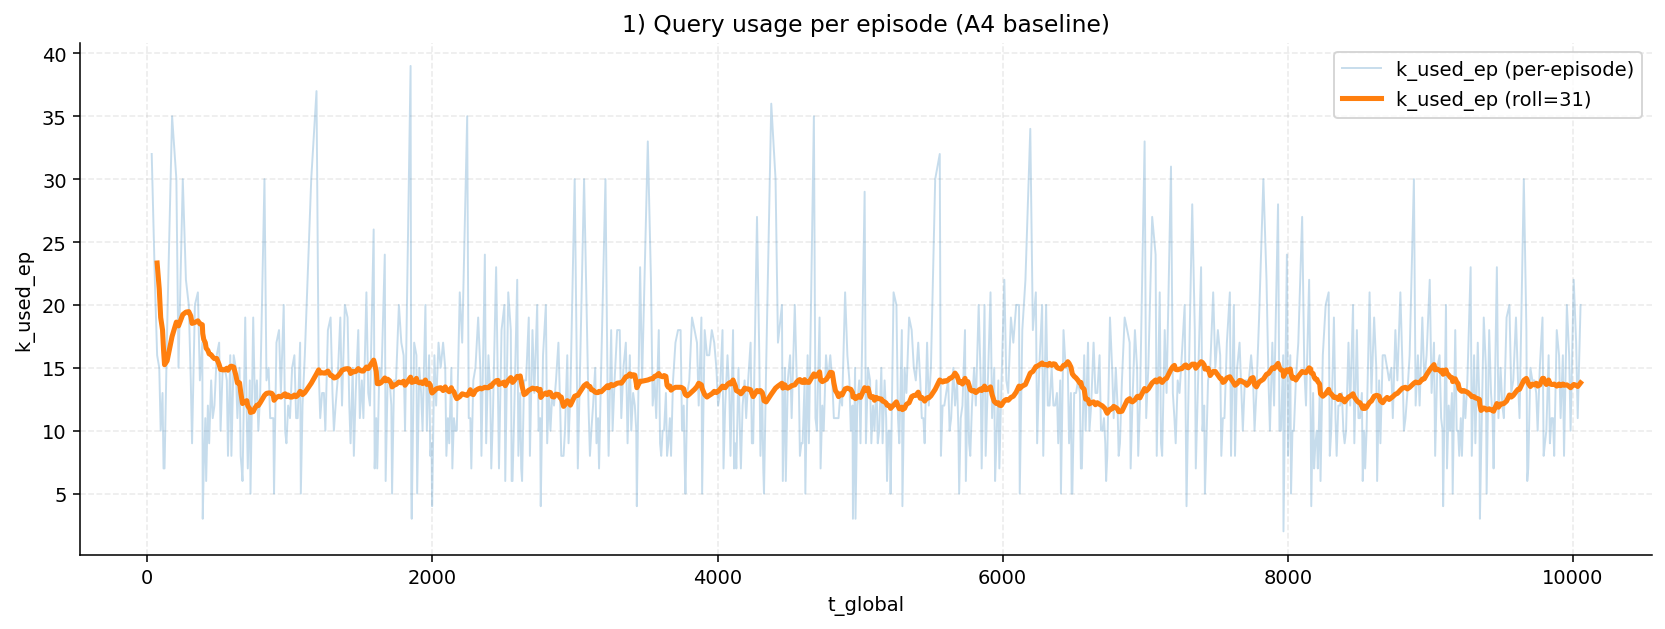

In [77]:
def plot_query_usage(steps_df: pd.DataFrame, upd_df: pd.DataFrame, roll=31, title="Query usage per episode"):
    _need_col(steps_df, "ep")
    _need_col(steps_df, "queried_oracle")
    _need_col(upd_df, "ep")
    _need_col(upd_df, "t_global")

    q_ep = (
        steps_df.dropna(subset=["ep"])
        .groupby("ep", as_index=False)["queried_oracle"]
        .sum()
        .rename(columns={"queried_oracle": "k_used_ep"})
    )

    anchor = upd_df.dropna(subset=["ep", "t_global"])[["ep", "t_global"]].drop_duplicates("ep", keep="last")
    d = q_ep.merge(anchor, on="ep", how="inner").sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d["k_used_ep"], alpha=0.25, linewidth=1, label="k_used_ep (per-episode)")
    plt.plot(d["t_global"], _rolling(d["k_used_ep"], roll), linewidth=2.6, label=f"k_used_ep (roll={roll})")
    plt.title(title)
    plt.xlabel("t_global")
    plt.ylabel("k_used_ep")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()

plot_query_usage(steps_df, df, roll=31, title="1) Query usage per episode (A4 baseline)")


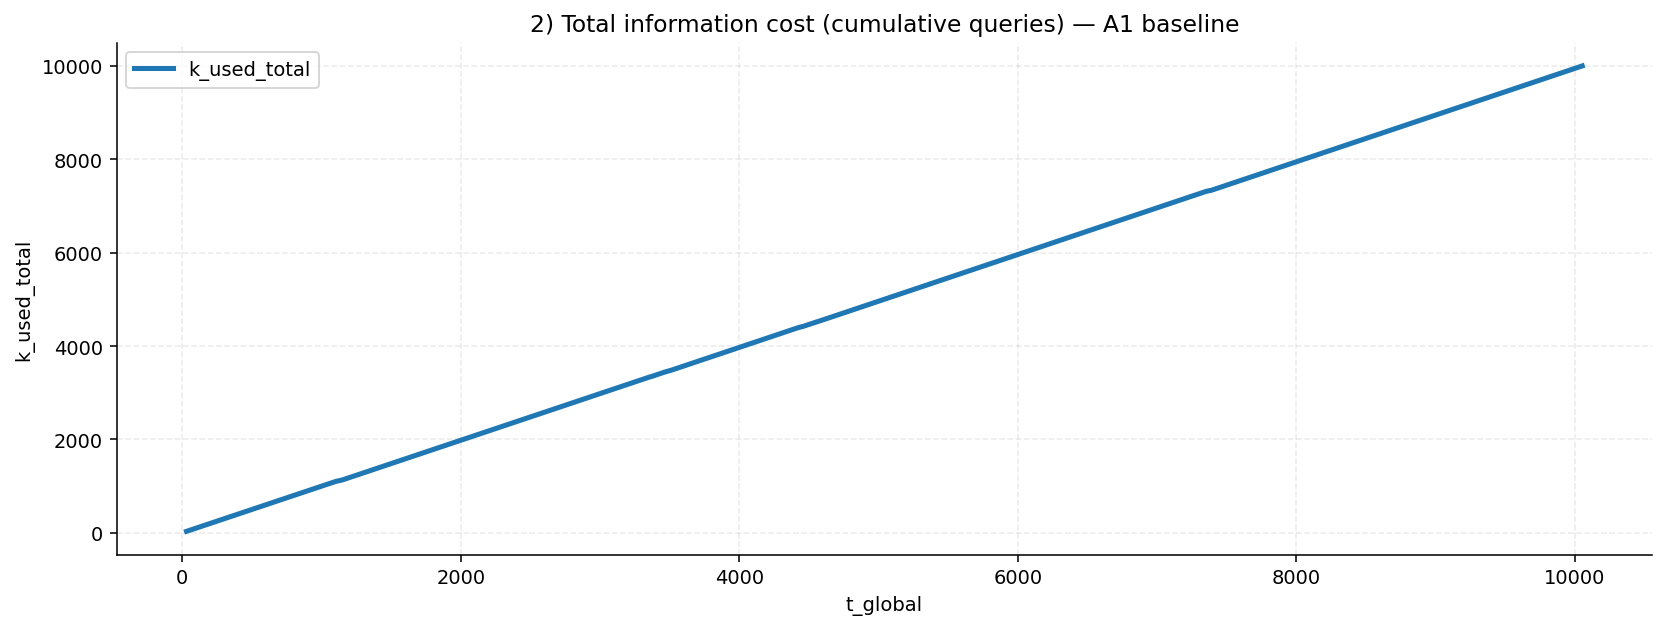

In [72]:
def plot_total_queries(upd_df: pd.DataFrame):
    _need_col(upd_df, "k_used_total")
    _need_col(upd_df, "t_global")

    d = upd_df.dropna(subset=["t_global", "k_used_total"]).sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d["k_used_total"], linewidth=2.6, label="k_used_total")
    plt.title("2) Total information cost (cumulative queries) — A1 baseline")
    plt.xlabel("t_global")
    plt.ylabel("k_used_total")
    _style_ax(plt.gca())
    plt.legend(loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()

plot_total_queries(df)


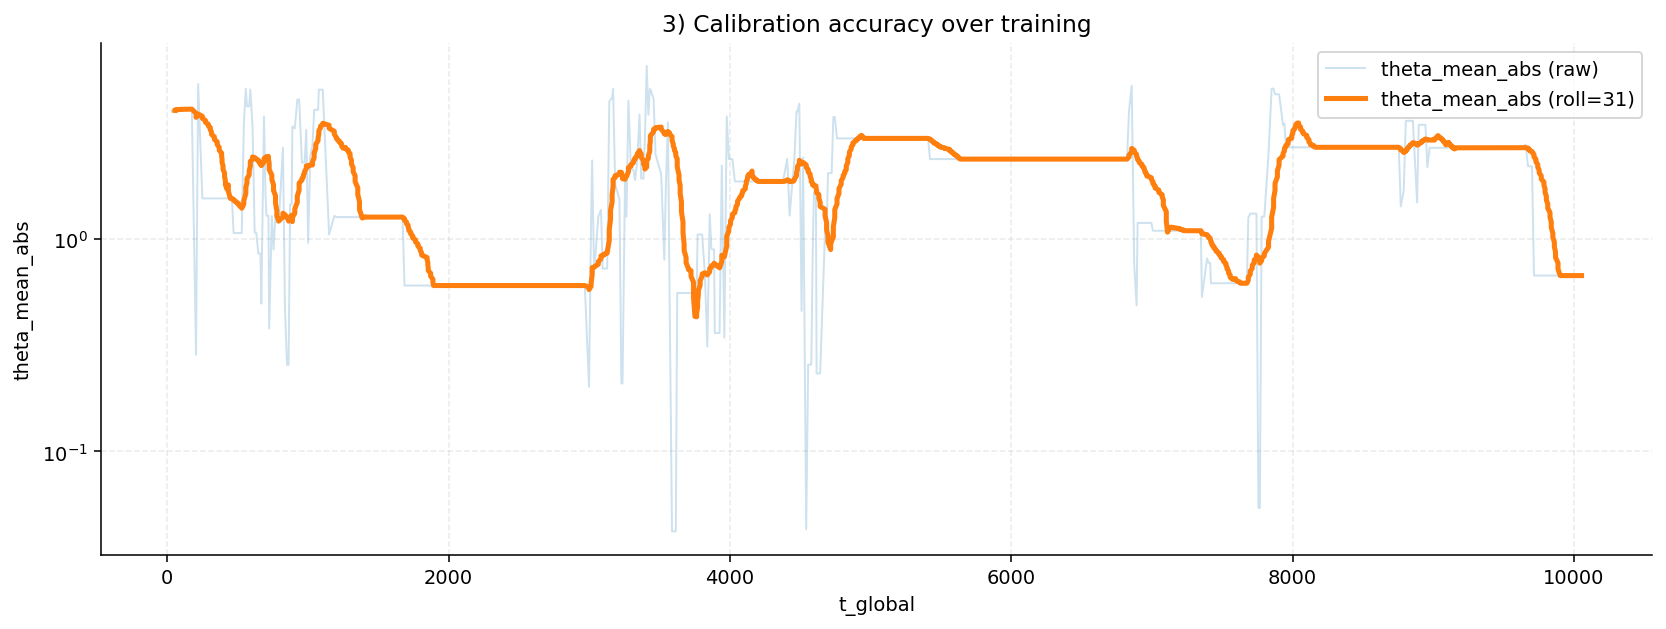

In [82]:
def plot_calibration_accuracy_long(upd_long: pd.DataFrame, roll=31, label=None):
    #columns include metric,value,t_global
    _need_col(upd_long, "t_global")
    _need_col(upd_long, "metric")
    _need_col(upd_long, "value")

    d = upd_long.copy()
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()
    mname = "theta_mean_abs"
    if mname not in set(d["metric"].astype(str).unique()):
        print("[available metrics top-30]")
        print(d["metric"].value_counts().head(30))
        raise KeyError("theta_mean_abs not found in long df (metric column).")

    s = (
        d[d["metric"] == mname]
        .dropna(subset=["t_global", "value"])
        .sort_values("t_global")
    )
    if s.empty:
        print("[skip] no rows for theta_mean_abs after filtering")
        return

    x = pd.to_numeric(s["t_global"], errors="coerce")
    y = pd.to_numeric(s["value"], errors="coerce")
    ok = x.notna() & y.notna()
    x = x[ok].to_numpy()
    y = y[ok].to_numpy()

    plt.figure(figsize=(12, 4.6))
    plt.plot(x, y, alpha=0.22, linewidth=1, label=f"{mname} (raw)")
    plt.plot(x, _rolling(pd.Series(y), roll), linewidth=2.6, label=f"{mname} (roll={roll})")

    plt.title("3) Calibration accuracy over training")
    plt.xlabel("t_global")
    plt.ylabel(mname)
    plt.yscale("symlog", linthresh=0.1)
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()
plot_calibration_accuracy_long(df, roll=31, label="A3")

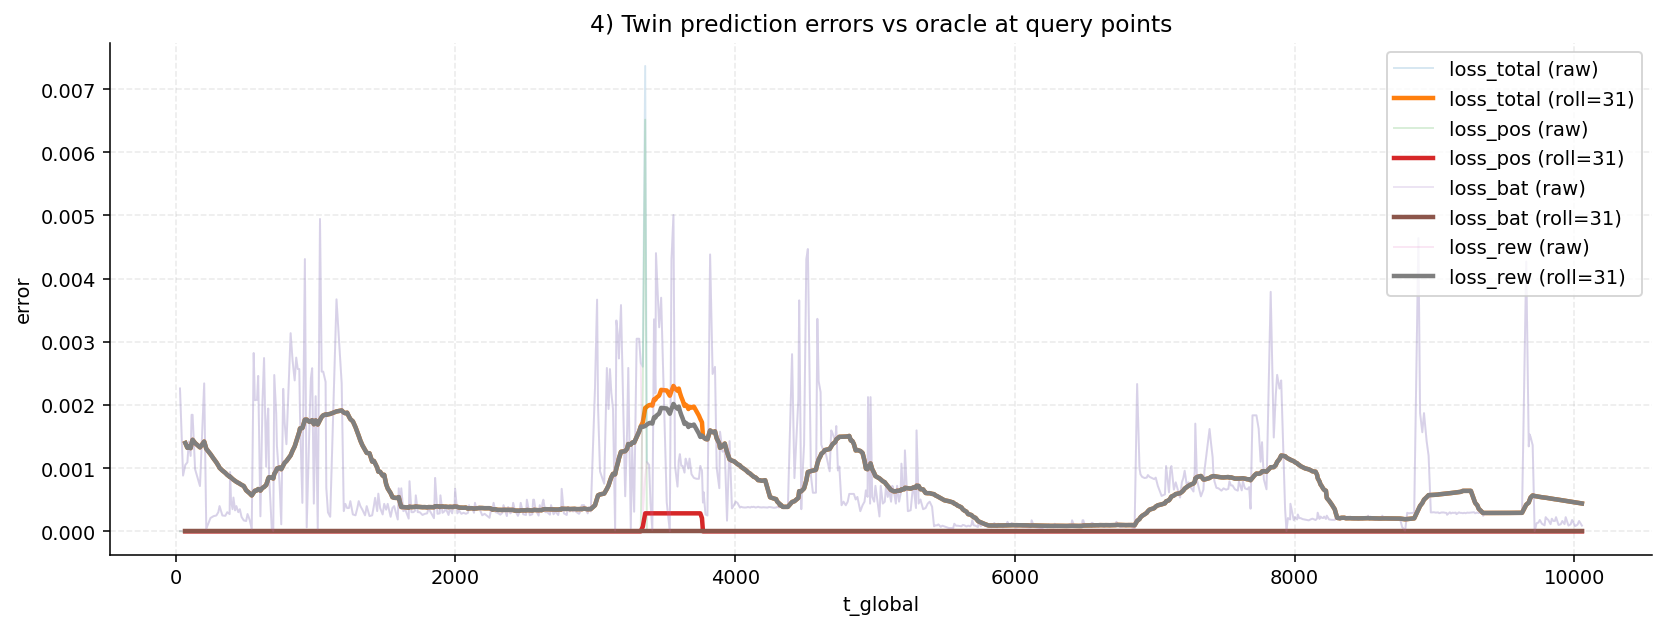

In [86]:
def plot_twin_prediction_errors_long(upd_long: pd.DataFrame, roll=31, label=None):
    _need_col(upd_long, "t_global")
    _need_col(upd_long, "metric")
    _need_col(upd_long, "value")

    d = upd_long.copy()
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()
    candidates = ["loss_total", "loss_pos", "loss_bat", "loss_rew"]
    have = set(d["metric"].astype(str).unique())
    metrics = [m for m in candidates if m in have]
    if not metrics:
        print("[available metrics top-40]")
        print(d["metric"].value_counts().head(40))
        raise KeyError(f"No expected error metrics found in long df. Expected one of: {candidates}")

    plt.figure(figsize=(12, 4.6))
    for m in metrics:
        s = (
            d[d["metric"] == m]
            .dropna(subset=["t_global", "value"])
            .sort_values("t_global")
        )
        if s.empty:
            continue

        x = pd.to_numeric(s["t_global"], errors="coerce")
        y = pd.to_numeric(s["value"], errors="coerce")
        ok = x.notna() & y.notna()
        x = x[ok].to_numpy()
        y = y[ok].to_numpy()

        plt.plot(x, y, alpha=0.18, linewidth=1, label=f"{m} (raw)")
        plt.plot(x, _rolling(pd.Series(y), roll), linewidth=2.3, label=f"{m} (roll={roll})")

    plt.title("4) Twin prediction errors vs oracle at query points")
    plt.xlabel("t_global")
    plt.ylabel("error")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()
def plot_twin_prediction_errors_long(upd_long: pd.DataFrame, roll=31, label=None):
    _need_col(upd_long, "t_global")
    _need_col(upd_long, "metric")
    _need_col(upd_long, "value")

    d = upd_long.copy()
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()
    candidates = ["loss_total", "loss_pos", "loss_bat", "loss_rew"]
    have = set(d["metric"].astype(str).unique())
    metrics = [m for m in candidates if m in have]
    if not metrics:
        print("[available metrics top-40]")
        print(d["metric"].value_counts().head(40))
        raise KeyError(f"No expected error metrics found in long df. Expected one of: {candidates}")

    plt.figure(figsize=(12, 4.6))
    for m in metrics:
        s = (
            d[d["metric"] == m]
            .dropna(subset=["t_global", "value"])
            .sort_values("t_global")
        )
        if s.empty:
            continue

        x = pd.to_numeric(s["t_global"], errors="coerce")
        y = pd.to_numeric(s["value"], errors="coerce")
        ok = x.notna() & y.notna()
        x = x[ok].to_numpy()
        y = y[ok].to_numpy()

        plt.plot(x, y, alpha=0.18, linewidth=1, label=f"{m} (raw)")
        plt.plot(x, _rolling(pd.Series(y), roll), linewidth=2.3, label=f"{m} (roll={roll})")

    plt.title("4) Twin prediction errors vs oracle at query points")
    plt.xlabel("t_global")
    plt.ylabel("error")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()
plot_twin_prediction_errors_long(df, roll=31, label="A3")

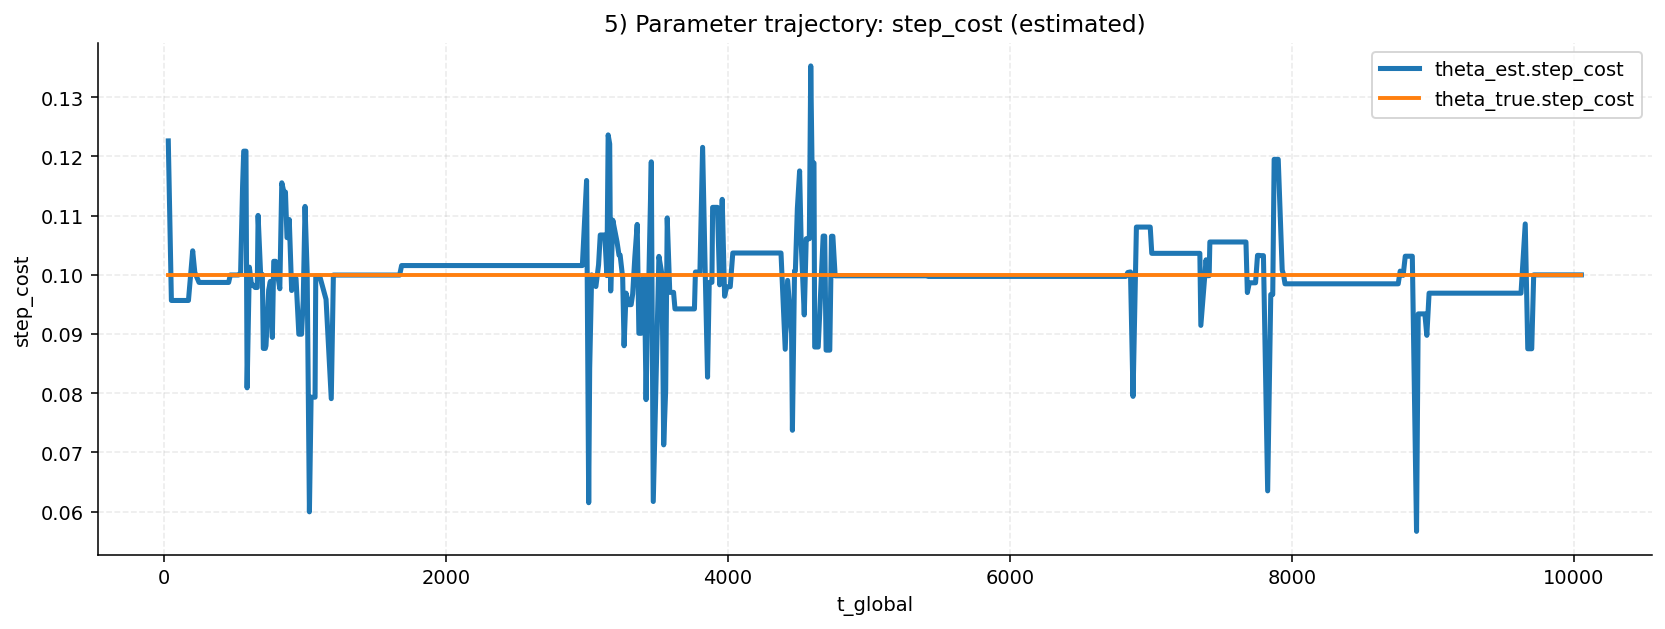

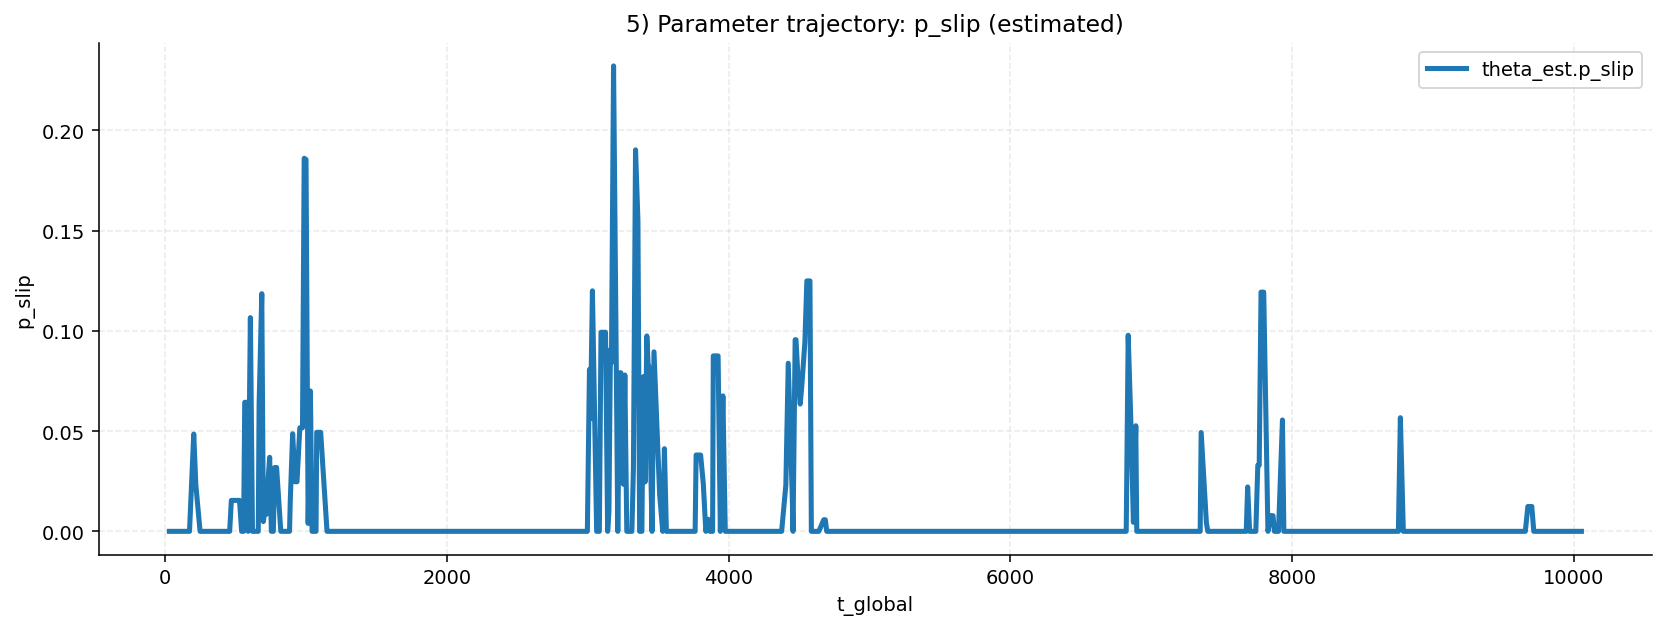

In [87]:
def plot_param_trajectory_long(upd_long: pd.DataFrame, param: str, roll=None, label=None, show_true=True):
    _need_col(upd_long, "t_global")
    _need_col(upd_long, "metric")
    _need_col(upd_long, "value")

    d = upd_long.copy()
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()

    est_m = f"theta_est.{param}"
    true_m = f"theta_true.{param}"

    have = set(d["metric"].astype(str).unique())
    if est_m not in have:
        print("[available theta_est metrics top-30]")
        print(d[d["metric"].astype(str).str.startswith("theta_est.")]["metric"].value_counts().head(30))
        raise KeyError(f"Missing {est_m} in long df. Ensure build_updates_long emits theta_est.*")

    plt.figure(figsize=(12, 4.6))
    s = (
        d[d["metric"] == est_m]
        .dropna(subset=["t_global", "value"])
        .sort_values("t_global")
    )
    x = pd.to_numeric(s["t_global"], errors="coerce")
    y = pd.to_numeric(s["value"], errors="coerce")
    ok = x.notna() & y.notna()
    x = x[ok].to_numpy()
    y = y[ok].to_numpy()

    plt.plot(x, y, linewidth=2.6, label=est_m)
    if roll is not None and roll > 1:
        plt.plot(x, _rolling(pd.Series(y), roll), linewidth=2.3, label=f"{est_m} (roll={roll})")

    if show_true and true_m in have:
        t = (
            d[d["metric"] == true_m]
            .dropna(subset=["t_global", "value"])
            .sort_values("t_global")
        )
        xt = pd.to_numeric(t["t_global"], errors="coerce")
        yt = pd.to_numeric(t["value"], errors="coerce")
        ok2 = xt.notna() & yt.notna()
        xt = xt[ok2].to_numpy()
        yt = yt[ok2].to_numpy()
        if len(xt):
            plt.plot(xt, yt, linewidth=2.0, label=true_m)

    plt.title(f"5) Parameter trajectory: {param} (estimated)")
    plt.xlabel("t_global")
    plt.ylabel(param)
    _style_ax(plt.gca())
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()
plot_param_trajectory_long(df, "step_cost", label="A3")
plot_param_trajectory_long(df, "p_slip", label="A3")


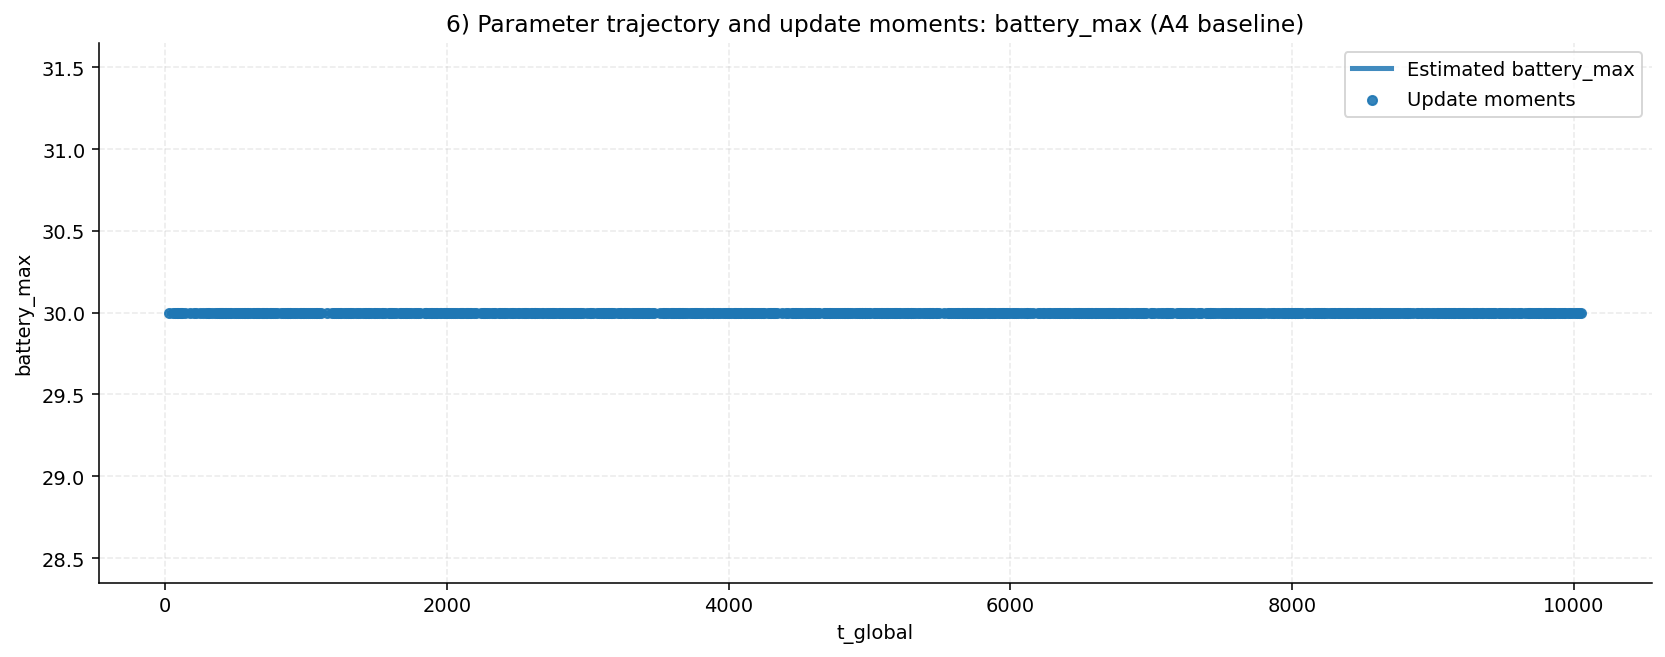

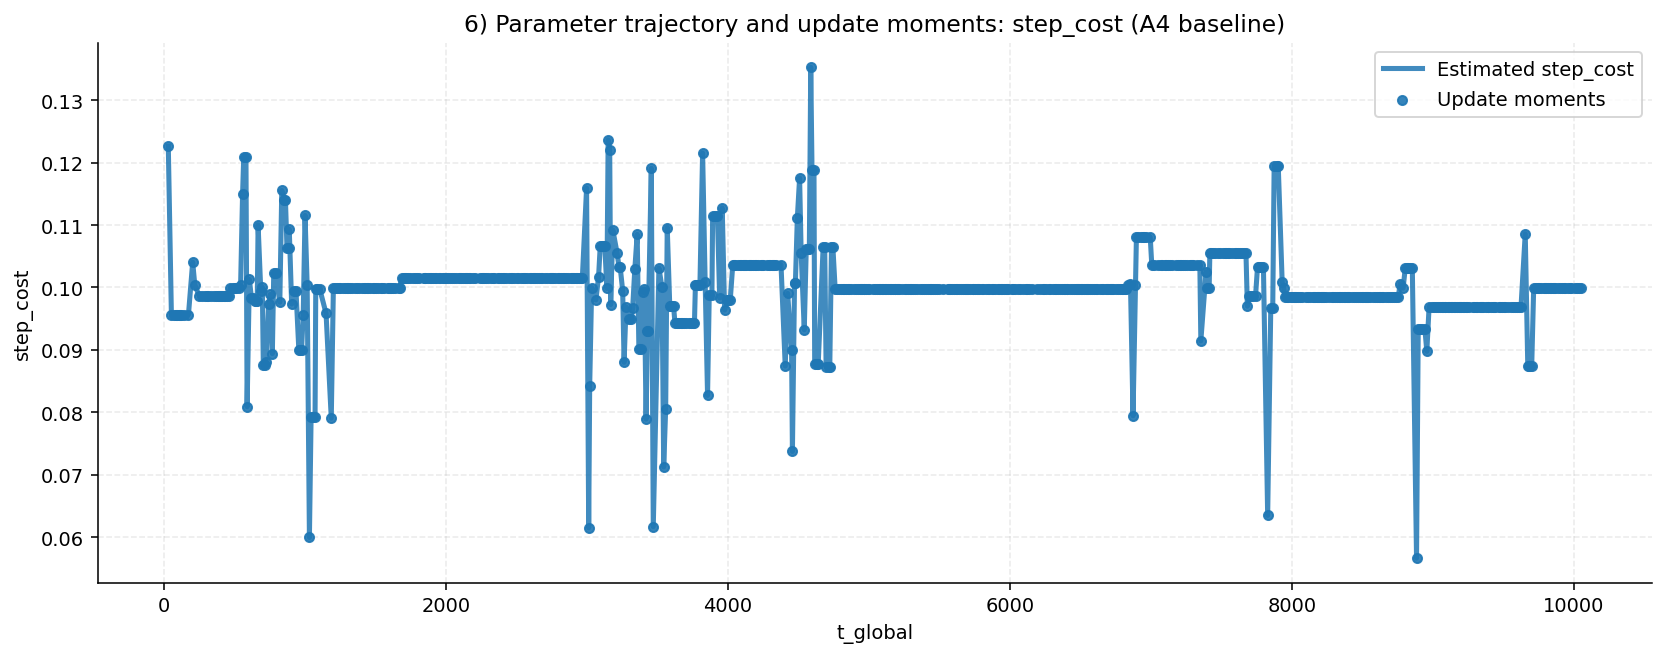

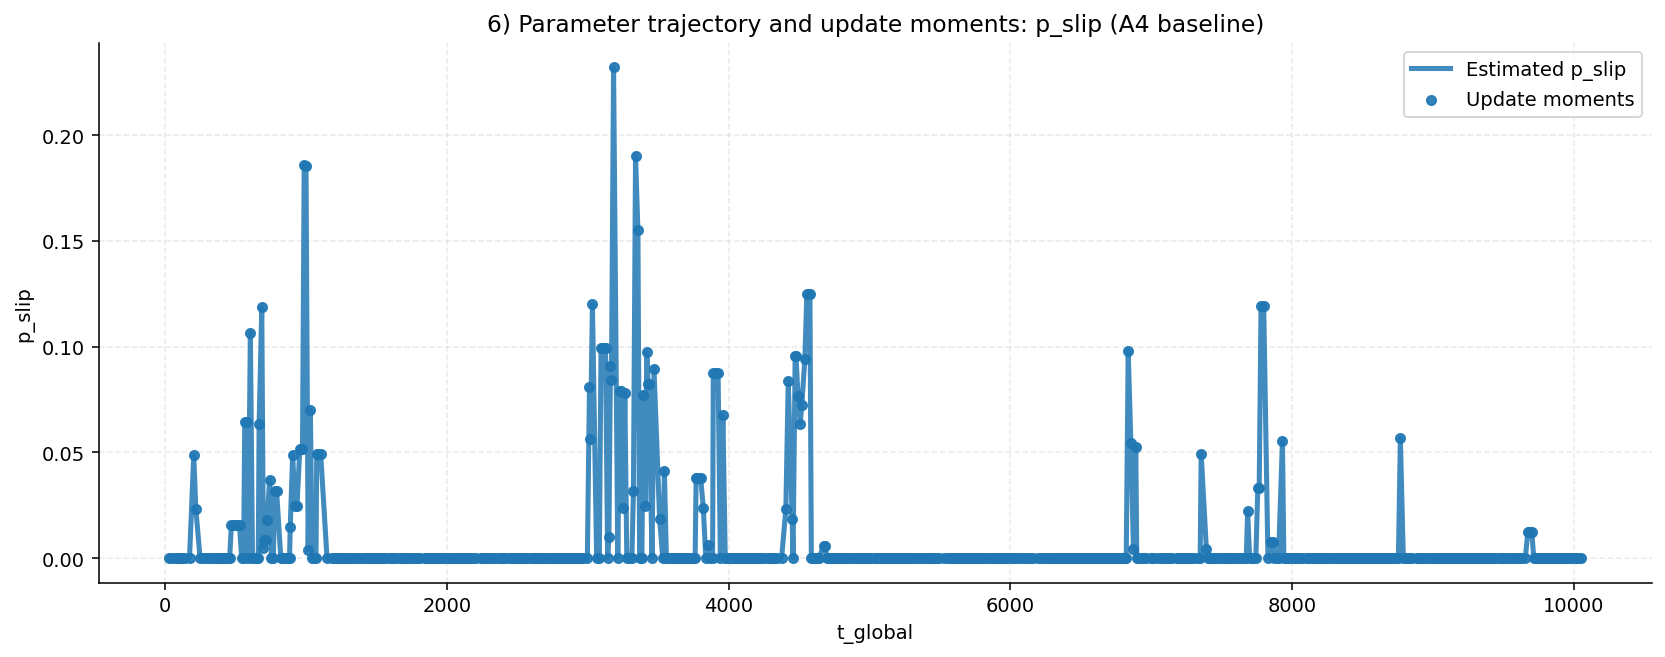

In [91]:
def plot_updates_vs_between(upd_long: pd.DataFrame, param: str,
                               markersize=22,
                               alpha_line=0.85,
                               alpha_pts=0.9,
                               label: Optional[str] = None):

    d = upd_long.copy()
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()

    est_m = f"theta_est.{param}"

    have = set(d["metric"].astype(str).unique())
    if est_m not in have:
        print("[available theta_est metrics top-30]")
        print(d[d["metric"].astype(str).str.startswith("theta_est.")]["metric"].value_counts().head(30))
        raise KeyError(f"Missing {est_m} in long df. Ensure build_updates_long emits theta_est.*")

    s = d[d["metric"] == est_m].dropna(subset=["t_global", "value"]).sort_values("t_global")
    if s.empty:
        print(f"[skip] no data for {est_m} after filtering")
        return

    x = pd.to_numeric(s["t_global"], errors="coerce").to_numpy()
    y = pd.to_numeric(s["value"], errors="coerce").to_numpy()
    ok = np.isfinite(x) & np.isfinite(y)
    x = x[ok]
    y = y[ok]

    plt.figure(figsize=(12, 4.8))
    plt.plot(x, y, linewidth=2.6, alpha=alpha_line, label=f"Estimated {param}")

    plt.scatter(x, y, s=markersize, alpha=alpha_pts,
                label="Update moments", zorder=5)

    plt.title(f"6) Parameter trajectory and update moments: {param} (A4 baseline)")
    plt.xlabel("t_global")
    plt.ylabel(param)
    _style_ax(plt.gca())
    plt.legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

plot_updates_vs_between(df, param="battery_max", label="A3")
plot_updates_vs_between(df, param="step_cost", label="A3")
plot_updates_vs_between(df, param="p_slip", label="A3")

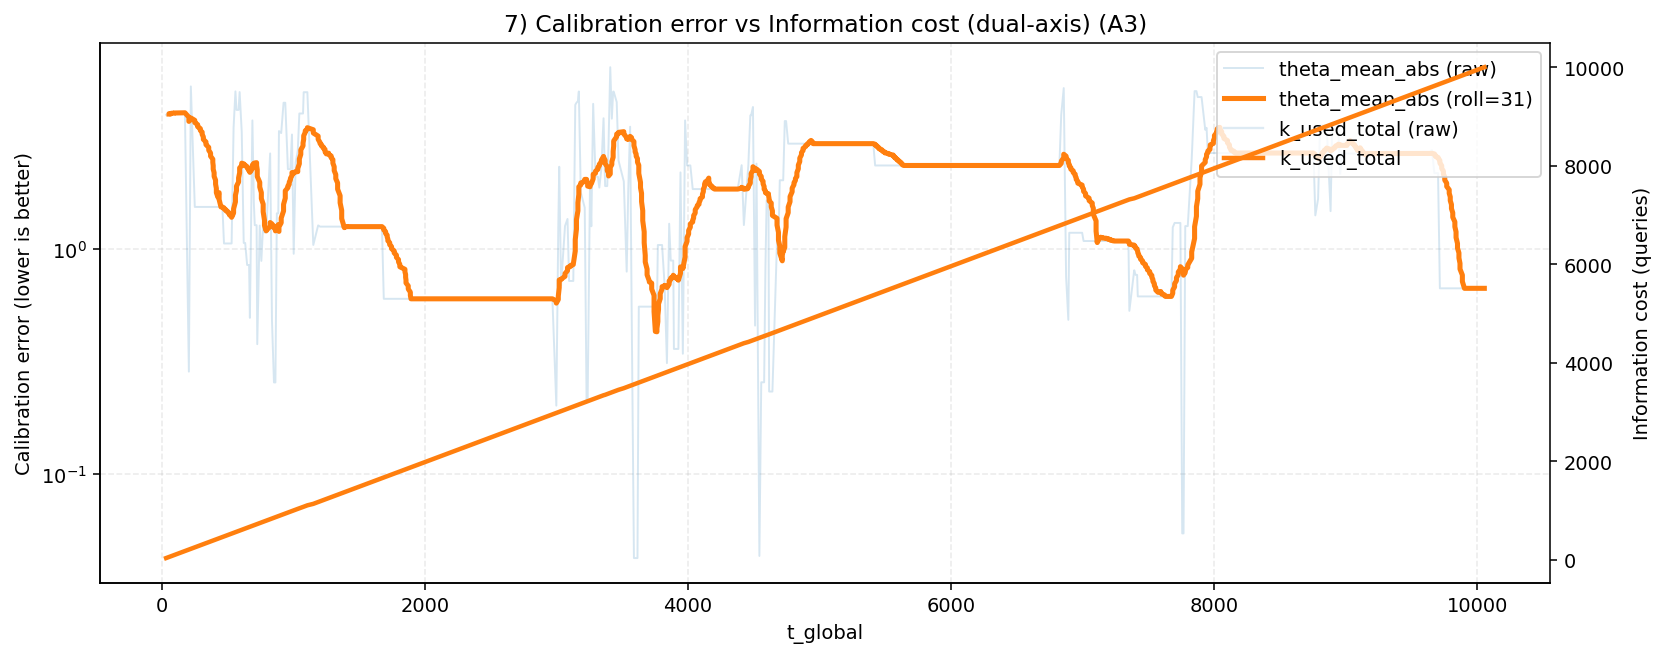

In [89]:
def _pick_accuracy_metric_long(d: pd.DataFrame) -> str:
    _need_col(d, "metric")
    have = set(d["metric"].dropna().astype(str).unique())
    for m in ["theta_mean_abs", "acc/theta_mean_abs"]:
        if m in have:
            return m

    # fallback: loss / surrogate errors (A4-style)
    for m in ["loss_total_after", "loss_total", "loss_total_before", "loss_total_after"]:
        if m in have:
            return m
    for m in ["loss_total_after", "loss_total_before", "pos_mse_after", "bat_mse_after"]:
        if m in have:
            return m

    raise KeyError(
        "No accuracy metric found in long df. Expected 'theta_mean_abs' (preferred) "
        "or loss/after/before variants like 'loss_total_after'."
    )

def plot_dual_axis_accuracy_queries_long(
    upd_long: pd.DataFrame,
    *,
    label: str | None = None,
    acc_metric: str | None = None,
    queries_col: str = "k_used_total",
    roll_acc: int | None = 31,
    roll_q: int | None = None,
    use_symlog: bool = True,
    title: str | None = None,
):
    # validate required columns
    for c in ["t_global", "metric", "value", queries_col]:
        _need_col(upd_long, c)

    d = upd_long.copy()

    # optional label filter
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()

    # pick accuracy metric
    if acc_metric is None:
        acc_metric = _pick_accuracy_metric_long(d)

    # slice to the metric and keep latest per t_global (safety)
    s_acc = (
        d[d["metric"].astype(str) == acc_metric]
        .dropna(subset=["t_global", "value", queries_col])
        .copy()
    )
    if s_acc.empty:
        print("[skip] no rows for selected acc_metric:", acc_metric)
        print("available metrics top-30:")
        print(d["metric"].value_counts().head(30))
        return

    # numeric coercion
    s_acc["t_global"] = pd.to_numeric(s_acc["t_global"], errors="coerce")
    s_acc["value"] = pd.to_numeric(s_acc["value"], errors="coerce")
    s_acc[queries_col] = pd.to_numeric(s_acc[queries_col], errors="coerce")

    s_acc = s_acc.dropna(subset=["t_global", "value", queries_col]).sort_values("t_global")

    # x/y series
    x = s_acc["t_global"]
    acc = s_acc["value"]
    q = s_acc[queries_col]

    acc_s = _rolling(acc, roll_acc) if roll_acc else acc
    q_s = _rolling(q, roll_q) if roll_q else q

    fig, ax1 = plt.subplots(figsize=(12, 4.8))

    ax1.plot(x, acc, alpha=0.18, linewidth=1, label=f"{acc_metric} (raw)")
    ax1.plot(x, acc_s, linewidth=2.6, label=f"{acc_metric} (roll={roll_acc})" if roll_acc else f"{acc_metric}")
    ax1.set_xlabel("t_global")
    ax1.set_ylabel("Calibration error (lower is better)")
    if use_symlog:
        ax1.set_yscale("symlog", linthresh=0.1)
    _style_ax(ax1)

    ax2 = ax1.twinx()
    ax2.plot(x, q, alpha=0.15, linewidth=1.2, label=f"{queries_col} (raw)")
    ax2.plot(
        x,
        q_s,
        linewidth=2.3,
        label=f"{queries_col}" + (f" (roll={roll_q})" if roll_q else "")
    )
    ax2.set_ylabel("Information cost (queries)")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right", frameon=True)

    if title is None:
        suffix = f" ({label})" if label else ""
        title = f"7) Calibration error vs Information cost (dual-axis){suffix}"
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_dual_axis_accuracy_queries_long(
    df,
    label="A3",
    acc_metric=None,
    queries_col="k_used_total",
    roll_acc=31,
    roll_q=None,
    use_symlog=True,
)

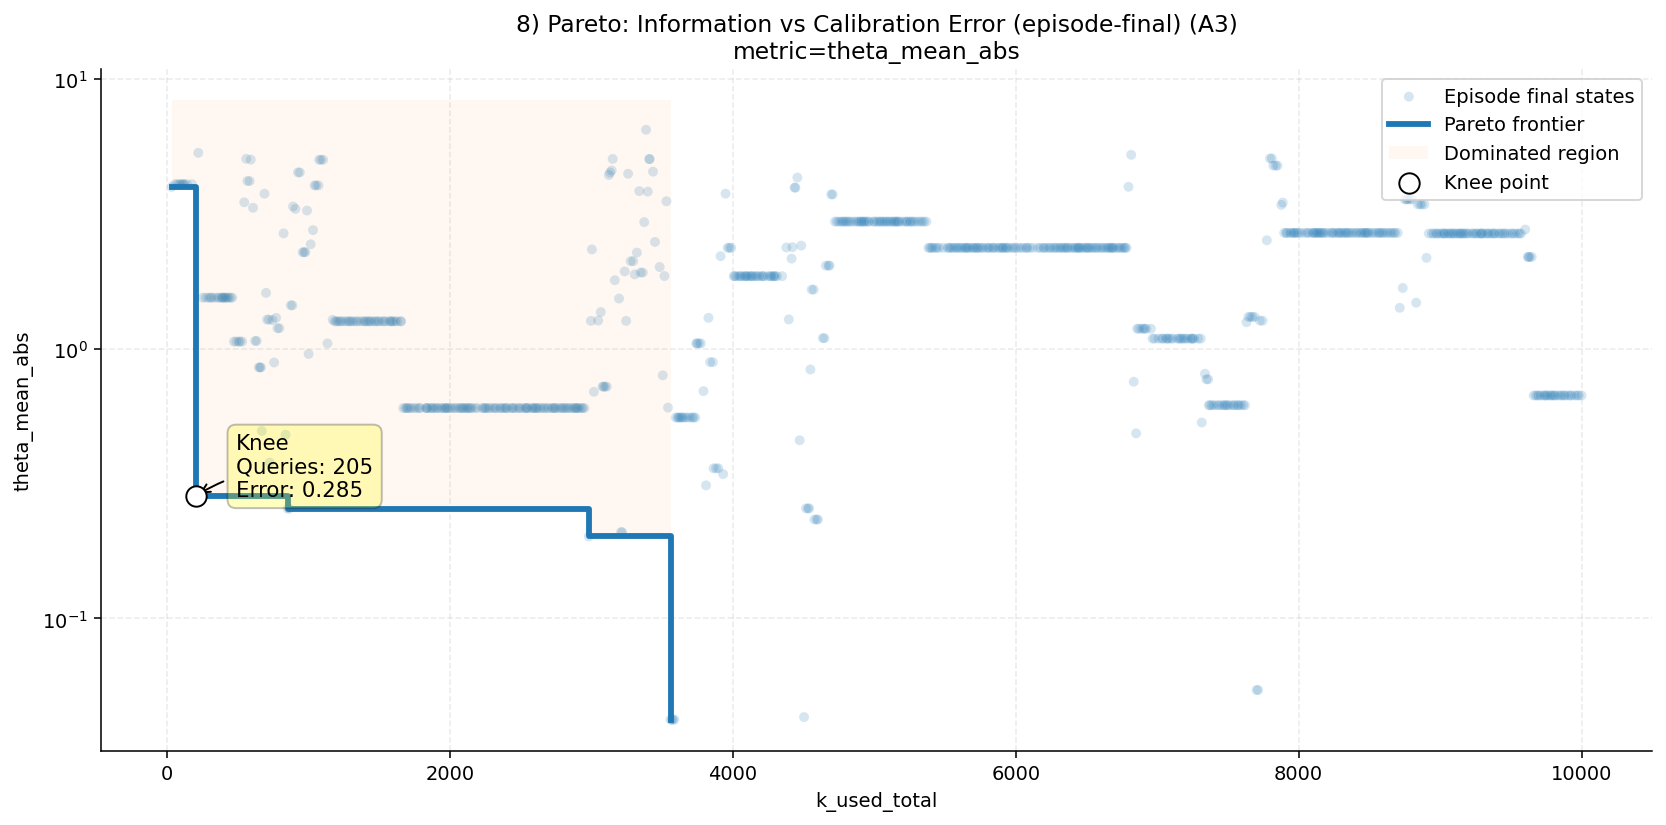

In [90]:
import numpy as np

def pareto_frontier_points(xs: np.ndarray, ys: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Sort by x-axis (cost/queries)
    order = np.argsort(xs)
    _x, _y = xs[order], ys[order]

    # non-dominated points
    px, py = [], []
    current_y_min = np.inf
    for i in range(len(_x)):
        if _y[i] < current_y_min:
            px.append(_x[i])
            py.append(_y[i])
            current_y_min = _y[i]

    return np.array(px), np.array(py)

def staircase_xy(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    sx = np.repeat(x, 2)[1:]
    sy = np.repeat(y, 2)[:-1]
    if len(sx) > 0: # Ensure arrays have data before slicing
        sx = np.concatenate(([x[0]], sx, [x[-1]]))
        sy = np.concatenate(([y[0]], sy, [y[-1]]))
    return sx, sy

def knee_max_distance_to_chord(px: np.ndarray, py: np.ndarray, y_transform: str | None = None) -> int:
    if len(px) < 2:
        return 0

    x1, y1 = px[0], py[0]
    x2, y2 = px[-1], py[-1]

    if y_transform == "log1p":
        y1, y2 = np.log1p(y1), np.log1p(y2)
        py_t = np.log1p(py)
    else:
        py_t = py

    # Calculate distances from points to the chord
    # Line equation: (y - y1)(x2 - x1) - (x - x1)(y2 - y1) = 0
    # Distance: |Ax + By + C| / sqrt(A^2 + B^2)
    # A = (y2 - y1), B = -(x2 - x1), C = -x1(y2 - y1) + y1(x2 - x1)
    A = (y2 - y1)
    B = -(x2 - x1)
    C = -x1 * (y2 - y1) + y1 * (x2 - x1)

    distances = np.abs(A * px + B * py_t + C) / np.sqrt(A**2 + B**2)

    return np.argmax(distances)

def _pick_accuracy_metric_long(d: pd.DataFrame) -> str:
    _need_col(d, "metric")
    have = set(d["metric"].dropna().astype(str).unique())

    for m in ["theta_mean_abs", "acc/theta_mean_abs"]:
        if m in have:
            return m

    for m in ["loss_total_after", "loss_total", "loss_total_before", "loss_total_after"]:
        if m in have:
            return m

    for m in ["loss_total_after", "loss_total_before", "pos_mse_after", "bat_mse_after"]:
        if m in have:
            return m

    raise KeyError(
        "No accuracy metric found in long df. Expected 'theta_mean_abs' (preferred) "
        "or loss/after/before variants like 'loss_total_after'."
    )

def episode_final_xy_from_long(
    upd_long: pd.DataFrame,
    *,
    label: str | None = None,
    x_col: str = "k_used_total",
    acc_metric: str | None = None,
) -> Tuple[pd.DataFrame, str]:
    d = upd_long.copy()
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()

    if acc_metric is None:
        acc_metric = _pick_accuracy_metric_long(d)

    # Filter to only the selected accuracy metric
    s_acc = d[d["metric"].astype(str) == acc_metric].copy()

    # Find the last update per episode for this metric
    # Group by ep and get the last row
    last_per_ep = s_acc.sort_values(["ep", "t_global"]).groupby("ep", as_index=False).tail(1)
    #  required columns are numeric and finite
    last_per_ep[x_col] = pd.to_numeric(last_per_ep[x_col], errors="coerce")
    last_per_ep["value"] = pd.to_numeric(last_per_ep["value"], errors="coerce")

    ep_xy = last_per_ep.dropna(subset=[x_col, "value"])[["ep", x_col, "value"]].rename(columns={x_col: "x", "value": "y"})

    return ep_xy, acc_metric

def last_update_per_episode_long(upd_long: pd.DataFrame, label: str | None = None) -> pd.DataFrame:
    d = upd_long.copy()
    if label is not None and "label" in d.columns:
        d = d[d["label"] == label].copy()
    if "event" in d.columns:
        d = d[d["event"].astype(str).isin(["oracle_update", "calib_update", "update"])].copy()

    for c in ["ep", "t_global", "k_used_total"]:
        if c not in d.columns:
            raise KeyError(f"Missing '{c}' in upd_long")
        d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d.dropna(subset=["ep", "t_global"]).sort_values(["ep", "t_global"])
    last = d.groupby("ep", as_index=False).tail(1)
    return last
def pareto_plot_episode_frontier_long(
    upd_long: pd.DataFrame,
    *,
    title: str,
    label: str | None = None,
    x_col: str = "k_used_total",
    acc_metric: str | None = None,
):
    ep_xy, picked = episode_final_xy_from_long(
        upd_long,
        label=label,
        x_col=x_col,
        acc_metric=acc_metric,
    )

    if ep_xy.empty:
        print("[skip] no episode-final points to plot.")
        return

    x = ep_xy["x"].to_numpy(float)
    y = ep_xy["y"].to_numpy(float)

    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, alpha=0.18, s=26, label="Episode final states", edgecolors="none")

    px, py = pareto_frontier_points(x, y)
    plt.yscale("symlog", linthresh=0.1)

    if len(px) >= 2:
        sx, sy = staircase_xy(px, py)
        k_idx = knee_max_distance_to_chord(px, py, y_transform="log1p")
        kx, ky = px[k_idx], py[k_idx]

        plt.plot(sx, sy, linewidth=3, label="Pareto frontier")

        y_top = plt.gca().get_ylim()[1]
        plt.fill_between(sx, sy, y_top, alpha=0.05, label="Dominated region")

        plt.scatter([kx], [ky], color="white", edgecolor="black", s=110, zorder=5, label="Knee point")
        plt.annotate(
            f"Knee\nQueries: {kx:.0f}\nError: {ky:.3f}",
            xy=(kx, ky),
            xytext=(kx + 0.08*(px.max()-px.min()+1e-9), ky),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.15"),
            fontsize=11,
            bbox=dict(boxstyle="round,pad=0.4", fc="yellow", alpha=0.25),
        )
    else:
        print("WARNING: frontier has <2 points; plotting only scatter.")

    plt.title(title + (f" ({label})" if label else "") + f"\nmetric={picked}")
    plt.xlabel(x_col)
    plt.ylabel(picked)
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()


pareto_plot_episode_frontier_long(
    df,
    label="A3",
    title="8) Pareto: Information vs Calibration Error (episode-final)",
    x_col="k_used_total",
    acc_metric="theta_mean_abs",
)

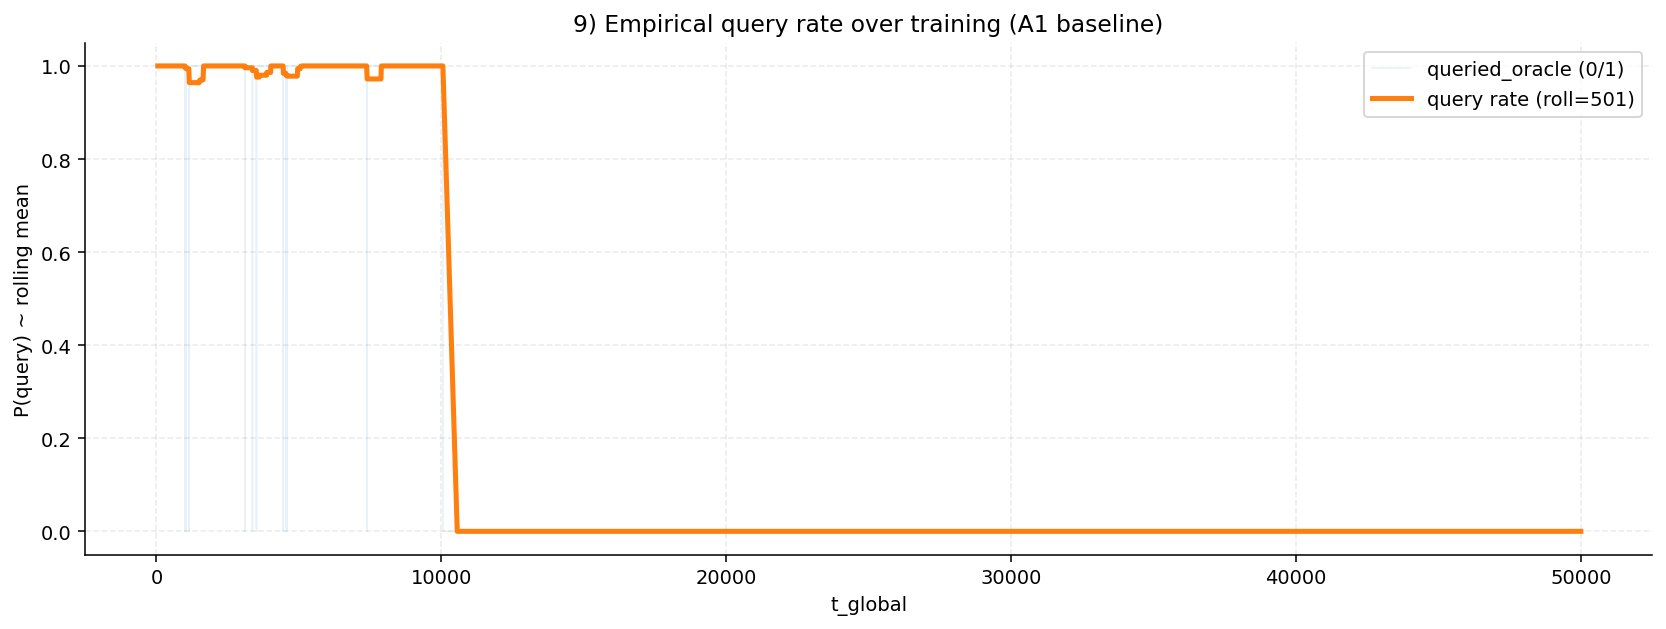

In [93]:
def plot_query_rate(steps_df: pd.DataFrame, roll=501):
    d = steps_df.copy()
    if "t_global" not in d.columns:
        raise KeyError("steps_df must contain 't_global'")
    if "queried_oracle" not in d.columns:
        raise KeyError("steps_df must contain 'queried_oracle'")

    _maybe_num(d, "t_global")
    _maybe_num(d, "queried_oracle")
    d = d.dropna(subset=["t_global", "queried_oracle"]).sort_values("t_global")

    plt.figure(figsize=(12, 4.6))
    plt.plot(d["t_global"], d["queried_oracle"], alpha=0.10, linewidth=0.8, label="queried_oracle (0/1)")
    plt.plot(d["t_global"], _rolling(d["queried_oracle"], roll), linewidth=2.6, label=f"query rate (roll={roll})")

    plt.title("9) Empirical query rate over training (A1 baseline)")
    plt.xlabel("t_global")
    plt.ylabel("P(query) ~ rolling mean")
    _style_ax(plt.gca())
    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.show()

plot_query_rate(steps_df, roll=501)